In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

In [28]:
df = pd.read_csv('dataset.csv')
df.head(100)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2019-01-01 01:11:02,4198470814557,fraud_Corwin-Gorczany,misc_net,3.35,Christie,Williamson,F,519 Jerry Views,...,41.4768,-95.3509,2036,Engineering geologist,1971-08-20,054e43b7ffbe6f2315c2ef123f2da0c0,1325380262,41.907592,-95.809232,0
96,96,2019-01-01 01:14:11,4423489490781412,fraud_Huels-Nolan,gas_transport,50.61,Christopher,Ortega,M,5045 Emily Wall,...,41.6858,-90.3706,1426,Agricultural consultant,1957-03-06,a76f5e9735622f062eb663f06c169a94,1325380451,41.027284,-89.416172,0
97,97,2019-01-01 01:14:11,3518234918950662,fraud_Jaskolski-Dibbert,grocery_net,50.74,Barbara,Lowe,F,67210 Lori Creek,...,33.6372,-96.6184,46563,Systems developer,1970-09-11,8ba96beff66354e33f9fe96051a9a4a3,1325380451,34.266941,-96.709668,0
98,98,2019-01-01 01:14:55,6593250708747804,fraud_DuBuque LLC,grocery_pos,186.73,Melissa,Meza,F,244 Abbott Parkway,...,26.7383,-80.2760,26551,Paramedic,1977-01-04,73e0bef38dd11227990b0e4e466d3706,1325380495,27.610009,-79.498110,0


In [3]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month


In [4]:
drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'job', 'trans_num' ]
df = df.drop(columns=drop_columns)

In [27]:
df.head(10)

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395
5,4767265376804500,607,2,94.63,0,40.3750,-75.2045,2158,1325376248,40.653382,-76.152667,0,0,1,1,86.097358
6,30074693890476,534,3,44.54,0,37.9931,-100.9893,2691,1325376282,37.162705,-100.153370,0,0,1,1,118.094855
7,6011360759745864,107,2,71.65,1,38.8432,-78.6003,6018,1325376308,38.948089,-78.540296,0,0,1,1,12.754714
8,4922710831011201,250,9,4.27,0,40.3359,-79.6607,1472,1325376318,40.351813,-79.958146,0,0,1,1,25.333883
9,2720830304681674,563,4,198.39,0,36.5220,-87.3490,151785,1325376361,37.179198,-87.485381,0,0,1,1,73.939714


In [6]:
#Encode Categorical Columns
cat_col = ['merchant', 'category', 'gender']
encoders = {}
for col in cat_col:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

In [7]:
#Function to calculate distance between transaction and merchant locations
def haversine(lat1, lon1, lat2, lon2):
    return np.array([geodesic((a,b), (c,d)).km for a,b,c,d in zip(lat1, lon1, lat2, lon2)])

#Separate columns for the distance calculation
df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [8]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [9]:
features = ['merchant', 'category','amt','cc_num','hour','day','month','gender','distance']
x = df[features]
y = df['is_fraud']

In [30]:
df[df['is_fraud']==1].head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
2449,2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1
2472,2472,2019-01-02 01:47:29,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1
2523,2523,2019-01-02 03:05:23,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1
2546,2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1
2553,2553,2019-01-02 03:55:47,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1


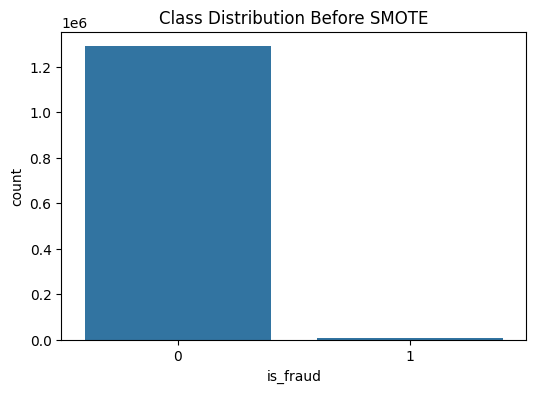

In [10]:
#Find number of fraudulent and non-fraudulent transactions
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title('Class Distribution Before SMOTE')
plt.show()

In [11]:
#Balance data using SMOTE
smote = SMOTE(random_state=42)
x_resample, y_resample = smote.fit_resample(x,y)

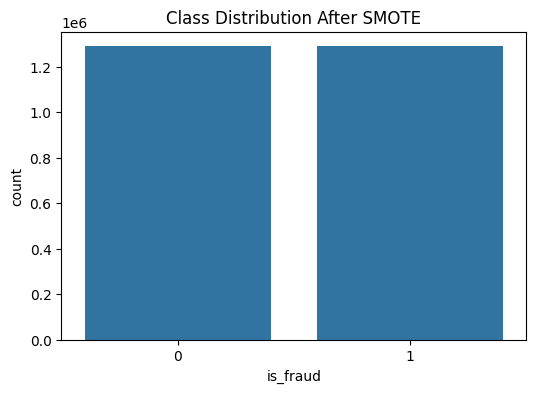

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title('Class Distribution After SMOTE')
plt.show()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.2, random_state=42)

In [14]:
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics='auc',
    is_unbalance=True,
    num_leaves=31,
    max_depth=1,
    n_estimators=200
)
lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,1
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [15]:
y_pred = lgb_model.predict(x_test)

In [16]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89    257186
           1       0.95      0.82      0.88    258482

    accuracy                           0.89    515668
   macro avg       0.89      0.89      0.89    515668
weighted avg       0.89      0.89      0.89    515668

ROC AUC Score: 0.8871689253714493


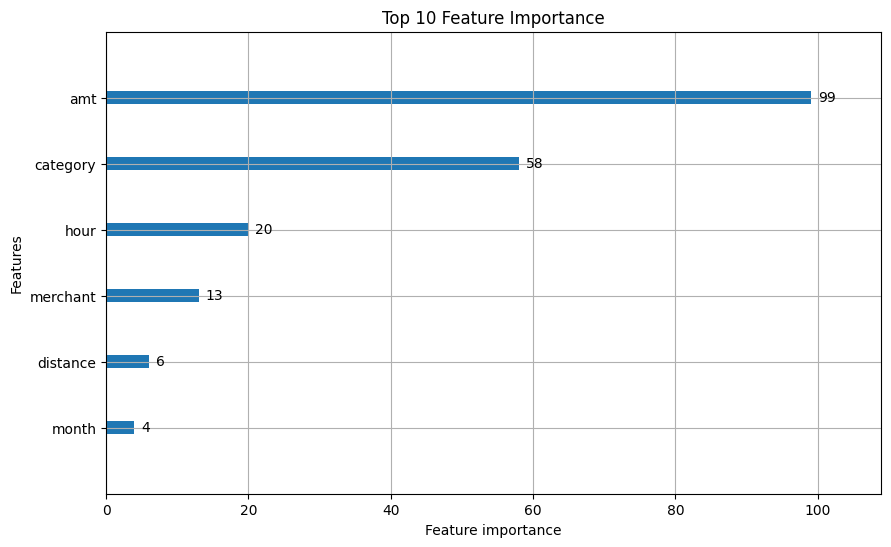

In [17]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split', figsize=(10,6))
plt.title('Top 10 Feature Importance')
plt.show()

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, lgb_model.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)

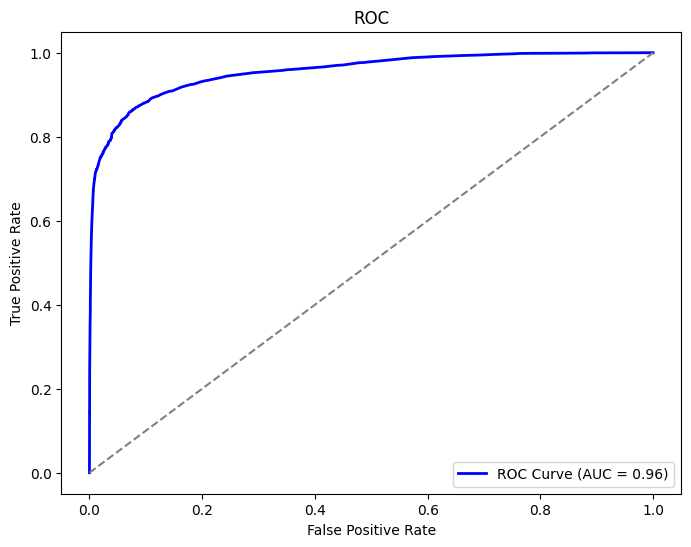

In [19]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='gray',linestyle='--')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [20]:
joblib.dump(lgb_model, 'fraud_detection_model.jb')
joblib.dump(encoders, 'label_encoders.jb')


['label_encoders.jb']